# Initialization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.utils.data as data_utils
import random
from copy import deepcopy

statistical_heterogeneity = 5

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # Change from 1 to 3 input channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)  # Adjust the size for CIFAR-10
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)  # Adjust the size for CIFAR-10
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def create_non_iid_partitions(dataset, num_clients):
    num_classes = 10
    class_indices = [[] for _ in range(num_classes)]
    
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Ensure randomness in class selection for each client
    all_classes = list(range(num_classes))
    
    client_local_datasets = []
    for i in range(num_clients):
        # Randomly select two major classes for each client
        major_classes = random.sample(all_classes, 2)

        # Allocate all data from the two major classes
        client_indices = class_indices[major_classes[0]] + class_indices[major_classes[1]]
        
        #Add a small number of samples from other classes
        minor_indices = []
        for cls in set(range(num_classes)) - set(major_classes):
            n_samples = len(class_indices[cls]) // num_clients // statistical_heterogeneity  # 50 times less than major classes
            minor_indices.extend(class_indices[cls][i * n_samples: (i + 1) * n_samples])

        client_indices = client_indices + minor_indices
        random.shuffle(client_indices)  # Shuffle to mix data from different classes
        client_local_datasets.append(data_utils.Subset(dataset, client_indices))

    return client_local_datasets

def create_iid_partitions(dataset, num_clients):

    client_datasets = []
    for i in range(num_clients):
        client_dataset = data_utils.Subset(dataset, list(range(i * len(dataset) // num_clients, (i + 1) * len(dataset) // num_clients)))
        client_datasets.append(client_dataset)
    return client_datasets

# Training set up using CIFAR-10

In [ ]:
myGPU = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(myGPU)
# load the data
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB channels
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
global_epochs = 20
local_epochs = 10
number_of_clients = 5
client_datasets=create_non_iid_partitions(trainset, number_of_clients)

# Federated Learning

In [55]:
def server_aggregate(model, state_dict_list):
    # average the model
    aggregated_state = {}
    for key,parameter in model.named_parameters():
        tensor_to_aggregate = []
        for client_state_dict in state_dict_list:
            client_tensor = client_state_dict[key].float()
            tensor_to_aggregate.append(client_tensor)
        
        stacked_tensor = torch.stack(tensor_to_aggregate,dim=0)
        mean_tensor = torch.mean(stacked_tensor,dim=0)
        aggregated_state[key] = mean_tensor
    model.load_state_dict(aggregated_state)

    return model 

def difference_models_norm_2(local_model, initial_model):
    tensor_1 = list(local_model.parameters())
    tensor_2 = list(initial_model.parameters())
    sub_norm = []
    for i in range(len(tensor_1)):
        s = torch.norm(tensor_1[i].to(myGPU) - tensor_2[i].to(myGPU),p=2)
        sub_norm.append(s)
    return sum(sub_norm)

def client_update(received_model, train_data, local_optimizer, loss_f, epoch,client_id,mu,algorithm,sys_heter):
    local_model = received_model.to(myGPU)
    initial_model = received_model.to(myGPU)

    random_chance = random.randint(0, 10) # Randomly decide if the client is weak or strong
    if random_chance >= sys_heter or algorithm == "FedProx":
    
        # print(f"Client {client_id+1} starts training...")
        local_model.train()
        
        for i in range(epoch):
            running_loss = 0.0

            for feature, label in train_data:
                local_optimizer.zero_grad()
                feature, label = feature.to(myGPU), label.to(myGPU)
                outputs = local_model(feature)
                local_loss = loss_f(outputs, label)
                loss_prox = (mu / 2) * difference_models_norm_2(local_model, initial_model) # perform model updates penalization using proximal term
                loss = local_loss + loss_prox
                loss.backward()
                local_optimizer.step()
                running_loss += loss.item()
      
            # print(f"Epoch {i+1} loss: {running_loss / len(train_data)}")
        # print("\n")
        return local_model.state_dict()
        # return model
    
    else: # If the client is weak, it will not train
        print(f"Client {client_id+1} dropped")
        return local_model.state_dict()

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_feature, test_labels in testloader:
         
            test_feature, test_labels = test_feature.to(myGPU), test_labels.to(myGPU)
            outputs = model(test_feature)
            test_loss = loss_function(outputs, test_labels)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
            test_loss += test_loss.item()
    accuracy = 100 * correct / total
    loss = test_loss / len(testloader)
    loss = loss.item()

    # print(f"Accuracy of the network: {accuracy}, Loss: {loss}")
    return [accuracy, loss]

def federated_learning(model, mu,client_datasets, testloader, optimizer, loss_function, global_epochs, local_epochs,algorithm,sys_heter, acc_history):
    
    for i, client_dataset in enumerate(client_datasets):
        client_labels = [trainset.targets[idx] for idx in client_dataset.indices]  # Access the labels for each subset
        unique_labels = np.unique(client_labels)
        # print(f"Client {i} has {len(unique_labels)} unique labels: {unique_labels}, and {len(client_dataset)} samples")
        
    # initial_phase = evaluate(model, testloader)     
    
    # Create a dataloader for each client
    client_dataloaders = [data_utils.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2) for dataset in client_datasets]
    global_history = []
    global_model = model.to(myGPU)
    client_model_lists = []
    client_optimizer_lists = []
    for k in range(number_of_clients):
        client_model_lists.append(deepcopy(global_model))
        client_optimizer_lists.append(optim.SGD(client_model_lists[k].parameters(), lr=0.01, momentum=0.9))

    for global_epoch in range(global_epochs):
        
        print(f"---- Global Round {global_epoch+1}: ----") 
        # print(f"'{'Global Round':=^100}'")
        state_dicts = []
      
        for client_id, client_dataloader in enumerate(client_dataloaders):
            client_state_dict = client_update(client_model_lists[client_id], client_dataloader, client_optimizer_lists[client_id], loss_function, local_epochs,client_id,mu,algorithm,sys_heter)
            state_dicts.append(client_state_dict)
        
        global_model = server_aggregate(global_model, state_dicts)
        model.load_state_dict(global_model.state_dict())

        client_model_lists.clear
        for k in range(number_of_clients):
            client_model_lists.append(deepcopy(model))
        acc = evaluate(model, testloader)[0]
        print("Current epoch global model accuracy: ", acc)
        acc_history.append(acc)
    return global_model

# Reinforcement Learning Environment setup.

In [ ]:
import gym
from gym import spaces

global_accuracy_histories = []
global_mu_histories = []
class FedProxTuningEnv(gym.Env):
    def __init__(self, fl_model,train_datasets, test_loader, optimizer, loss_function, global_epochs=2, local_epochs=5, algorithm='FedProx', sys_heter=5):
        super(FedProxTuningEnv, self).__init__()
        self.global_accuracy_history = []
        self.global_mu_history = []
        self.global_step = 0
        self.global_loss_min = 100;
        self.fl_model = fl_model
        self.train_datasets = train_datasets
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.global_epochs = global_epochs
        self.local_epochs = local_epochs
        self.algorithm = algorithm
        self.sys_heter = sys_heter

        self.is_first_round = True
        self.current_round = 0
        self.current_mu = 1  # Initial mu value
        # Define action and observation space
        self.action_space = spaces.Discrete(2)  # Actions: 0 for decreasing mu, 1 for increasing mu
        # self.action_space = spaces.Box(low=0.01, high=10.0) 
        self.observation_space = spaces.Dict({
            'mu': spaces.Box(low=np.array([0.0]), high=np.array([10.0]), dtype=np.float32),
            'accuracy': spaces.Box(low=np.array([0]), high=np.array([100]), dtype=np.float32),
            'loss': spaces.Box(low=np.array([0]), high=np.array([100]), dtype=np.float32),
            'round': spaces.Discrete(100)

        })
        spaces.Box(low=np.array([0.0, 0, 0]), high=np.array([10.0, 100, 3]), dtype=np.float32)

    def reset(self):
        
        self.global_accuracy_history = []
        self.global_mu_history = []
        self.global_loss_min = 100;


        self.is_first_round = True
        self.current_round = 0
        # Use the federated learning model for evaluation
        print(f"\n'{'Restarting Environment':=^100}'\n")
        initial_metrics = evaluate(self.fl_model, self.test_loader)  # Make sure this is the CNN model
        print("Current accuracy: ", initial_metrics[0], "Current loss: ", initial_metrics[1])
        print("Current mu: ", self.current_mu)
        self.fl_model = CNN().to(myGPU)
        self.optimizer = optim.SGD(self.fl_model.parameters(), lr=0.01, momentum=0.9)
        new_observations = {
            'mu': self.current_mu,
            'accuracy': initial_metrics[0],
            'loss': initial_metrics[1],
            'round': self.current_round
        }
        return new_observations

    def step(self, action):
        self.current_round += 1
        print(f"\n'{'Stepping':=^50}'\n")
        # Adjust mu based on action
        print(f'Action take: {action}')
        if (self.is_first_round):
            self.is_first_round = False
        else:
            # self.current_mu = action[0]
            # print("Currnet mu:", self.current_mu)
            if action == 0 and self.current_mu >= 0.02:  # Ensure mu stays positive
                print(f'Decreasing mu to {self.current_mu - 0.01}')
                self.current_mu -= 0.01
            elif action == 1 and self.current_mu < 10.0:  # Upper bound for mu
                print(f'Increasing mu to {self.current_mu + 0.01}')
                self.current_mu += 0.01
        
        previous_metrics = evaluate(self.fl_model, self.test_loader)
        # Run one global epoch of federated learning with the current mu
        # print(f'Running global epoch {self.current_round + 1} with mu = {self.current_mu}')
        print(f"\n'{'Start Federated Learning':-^50}'\n")
        global_model = federated_learning(self.fl_model, self.current_mu, self.train_datasets, self.test_loader, self.optimizer, self.loss_function, self.global_epochs, self.local_epochs, self.algorithm, self.sys_heter)
        
        current_metrics = evaluate(global_model, self.test_loader)
        if (current_metrics[1] < self.global_loss_min):
            self.global_loss_min = current_metrics[1]
        
        # Update the state

        state ={
            'mu': self.current_mu,
            'accuracy': current_metrics[0],
            'loss': current_metrics[1],
            'round': self.current_round
        }
        # Reward is based on improvement in accuracy
        # reward = current_metrics[0] - previous_metrics[0]  # Change in accuracy
        reward = current_metrics[0] - self.current_round * 0.2
        # print(f'Previous Accuracy: {previous_metrics[0]}')
        # print(f'Previous Loss: {previous_metrics[1]}')
        # print(f'Current Accuracy: {current_metrics[0]}')
        # print(f'Current Loss: {current_metrics[1]}')
        # print(f'New state: {state}')
        print(f'Reward: {reward}')
        print(f"\n'{'End Federated Learning':-^50}'\n")
        self.global_accuracy_history.append(current_metrics[0])
        # format mu to 2 decimal places
        format_mu = "{:.2f}".format(self.current_mu)
        self.global_mu_history.append(format_mu)
        self.global_step = self.global_step + 1
        loss_diff = abs(current_metrics[1] - previous_metrics[1])
        if ((loss_diff <= 0.0001) or (self.global_step == 100) or (current_metrics[1] - self.global_loss_min > 0.05)):
            global_accuracy_histories.append(self.global_accuracy_history)
            global_mu_histories.append(self.global_mu_history)
            print("Current global accuracies && mus:")
            print(self.global_accuracy_history)
            print(self.global_mu_history)
            done = True
        else:
            done = False
    
        return state, reward, done, {}

    def render(self, mode='console'):
        if mode == 'console':
            print(f'Round: {self.current_round}, Mu: {self.current_mu}')

# 

In [ ]:
from stable_baselines3 import PPO

fl_model = CNN().to(myGPU)
# old_global_model = None
optimizer = optim.SGD(fl_model.parameters(), lr=0.01, momentum=0.9)
# Instantiate the environment
env = FedProxTuningEnv(fl_model, client_datasets, testloader, optimizer, loss_function)

# Instantiate the agent
modelRL = PPO("MultiInputPolicy", env, verbose=1, n_steps=5)

# Train the agent
modelRL.learn(total_timesteps=100)


print(global_accuracy_histories)
print(global_mu_histories)


---- Global Round 1: ----
---- Global Round 2: ----
---- Global Round 3: ----
---- Global Round 4: ----
---- Global Round 5: ----
---- Global Round 6: ----
---- Global Round 7: ----
---- Global Round 8: ----
---- Global Round 9: ----
---- Global Round 10: ----
---- Global Round 11: ----
---- Global Round 12: ----
---- Global Round 13: ----
---- Global Round 14: ----
---- Global Round 15: ----
---- Global Round 16: ----
---- Global Round 17: ----
---- Global Round 18: ----
---- Global Round 19: ----
---- Global Round 20: ----


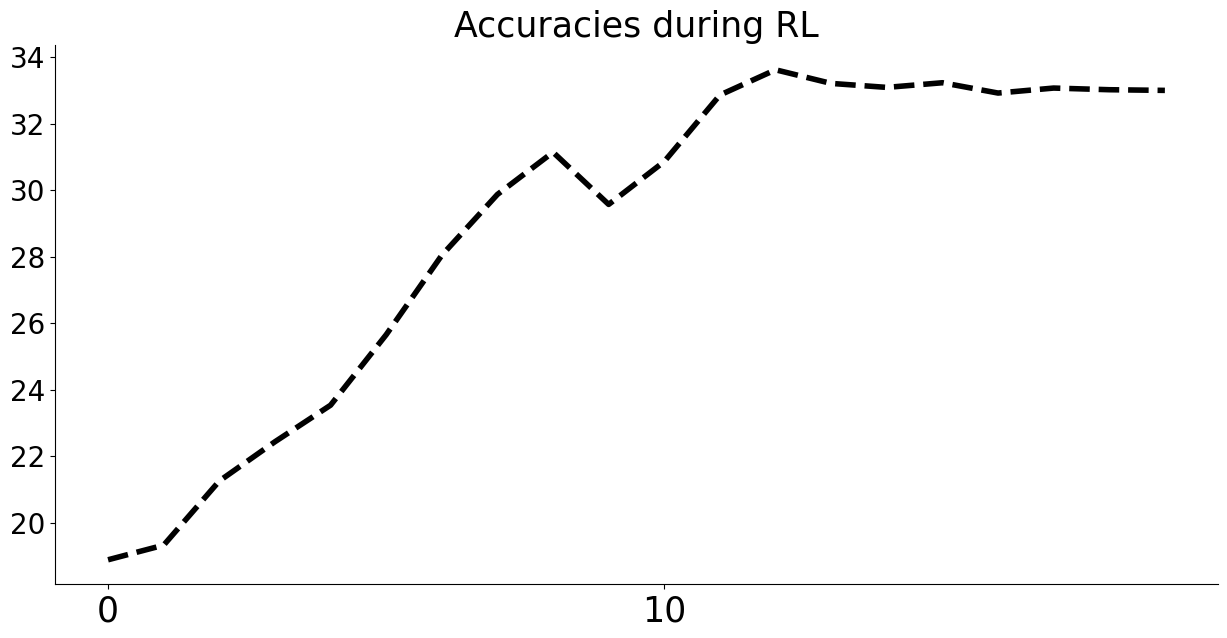

In [56]:
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np

tmp_model = CNN().to(myGPU)
optimizer = optim.SGD(tmp_model.parameters(), lr=0.01, momentum=0.9)
acc = []
federated_learning(tmp_model, 0.01, client_datasets, testloader, optimizer, loss_function, 20, 5, 'FedProx', 5, acc_history=acc)

plt.figure(figsize=(15, 7),facecolor='white')
plt.title('Accuracies during RL',fontsize=25,color='black')
plt.plot(acc, label='Accuracy', color="black", linestyle="dashed", linewidth=4)
plt.xticks(np.arange(0, len(acc), 10),fontsize=25,color='black')
plt.yticks(fontsize=20,color='black')
ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_facecolor('white')
plt.show()